# Pre-employment coursework
## Exercise 3 - Variational Autoencoder

- **Author:** Jan Xu
- **Model:** A Variational Autoencoder
- **Aim:** Model should be trained to generate new instances of the training data.
- **Sources:** Doerch, (2016), *Tutorial on Variational Autoencoders*, https://arxiv.org/pdf/1606.05908.pdf

In [1]:
# Imports
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)

import torchvision
from torchvision.transforms import transforms

from utils import *

print(torch.__version__)
print(torchvision.__version__)

1.3.0.post2
0.4.1.post2


## Load the MNIST dataset

In [2]:
# Define transform (binarise images for higher precision)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda img: torch.round(img))])

MNIST_set = torchvision.datasets.MNIST(root='../data', train=True,
                                       download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='../data', train=False,
                                      download=True, transform=transform)

train_set, val_set = train_val_split(MNIST_set, 0.1)

## Define model

In [3]:
class Encoder(nn.Module):
    """
    Simple CNN and fully connected encoder model.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), # 32 14 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 64 7 7
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.linear = nn.Linear(64 * 7 * 7, latent_dim * 2)
    
    def forward(self, inputs):
        layered = self.encoder_layers(inputs)
        reshaped = layered.view(-1, 64 * 7 * 7)
        encoded = self.linear(reshaped)
        return encoded

In [4]:
class Decoder(nn.Module):
    """
    Simple CNN and fully connected decoder model.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 7 * 7 * 12)
        self.decoder_layers = nn.Sequential(
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 24, 3, 2, 0), # 64 15 15
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 36, 2, 2, 1), # ? 28 28
            nn.BatchNorm2d(36),
            nn.ConvTranspose2d(36, 1, 3, 1, 1))
        
    def forward(self, inputs):
        linear = self.linear(inputs)
        reshaped = linear.view(-1, 12, 7, 7)
        decoded = self.decoder_layers(reshaped)
        return decoded

In [5]:
class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder models.
    """
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.latent_dim)
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def inference(self, inputs):
        """
        Inference model. Encoded inputs return Gaussian parameters for
        modelling the latent space. The conditional latent distribution
        q(z|x) is then modelled with these parameters by sampling with
        the reparameterisation trick.
        """
        
        q_z_cond_x_params = self.encoder(inputs)
        q_z_cond_x_mu, q_z_cond_x_sigma_arg = torch.chunk(q_z_cond_x_params, chunks=2, dim=1)
        q_z_cond_x_sigma = self._softplus(q_z_cond_x_sigma_arg)
        z = self.sample(q_z_cond_x_mu, q_z_cond_x_sigma)
        log_q_z_cond_x = self._normallogprob(q_z_cond_x_mu, q_z_cond_x_sigma, z).sum(dim=1)
        return z, log_q_z_cond_x
    
    def generative(self, z, inputs):
        """
        Generative model. Computes the joint log-distribution
        
            log[p(x,z)] = log[p(x|z)] + log[p(z)]
        
        by computing the two components on the right-hand side which are
        the conditional distribution of the generated images and the prior
        distribution of the latent variables. The former is simply a binary
        cross-entropy loss between generated and real images, and the prior
        is modelled as a unit Gaussian.
        """
        
        p_z_mu = torch.zeros(z.shape)
        p_z_sigma = torch.ones(z.shape)
        log_p_z = self._normallogprob(p_z_mu, p_z_sigma, z).sum(dim=1)
        logits = self.decoder(z)
        log_p_x_cond_z = self._bernoullilogprob(logits, inputs).sum(dim=(1, 2, 3))
        log_p_x_and_z = log_p_x_cond_z + log_p_z
        return log_p_x_and_z
    
    def sample(self, mu, sigma):
        """
        Sampling from latent distribution, using the reparametrisation trick.
        """
        
        eps = torch.randn(sigma.shape)
        z = mu + sigma * eps
        return z
    
    def forward(self, inputs):
        """
        Forward pass of model. Returns ELBO of the batch.
        """
        
        z, log_q_z_cond_x = self.inference(inputs)
        log_p_x_and_z = self.generative(z, inputs)
        elbo = (log_p_x_and_z - log_q_z_cond_x).sum(dim=0)
        return elbo
    
    def _normallogprob(self, mu, sigma, z):
        var = torch.pow(sigma, 2)
        return -0.5 * torch.log(2 * np.pi * var) - torch.pow(z - mu, 2) / (2 * var)
    
    def _bernoullilogprob(self, logits, inputs):
        # bernoulli log prob is equivalent to negative binary cross entropy
        return -nn.BCEWithLogitsLoss(reduction='none')(logits, inputs)
    
    def _softplus(self, scale):
        return nn.Softplus()(scale)

In [6]:
latent_dim = 64
print("Number of parameters in model with latent_dim={0}: {1}"
      .format(latent_dim, Autoencoder(latent_dim).num_params))

Number of parameters in model with latent_dim=64: 465341


## Training

In [7]:
param_names = ('init_lr', 'batch_size', 'latent_dim')
parameters = OrderedDict(
    run = [0.001, 128, 64]
)

,run,epoch,train loss,validation loss,epoch duration,run duration,init_lr,batch_size,latent_dim
0,1,1,205.493534,198.561559,381.298516,390.424812,0.001,128,64
1,1,2,118.672750,119.841816,374.782331,765.964806,0.001,128,64
2,1,3,104.274712,104.325760,377.409932,1144.122925,0.001,128,64
3,1,4,97.736199,98.229250,392.451517,1537.296689,0.001,128,64
4,1,5,94.263424,94.397394,425.472433,1963.631734,0.001,128,64
...,...,...,...,...,...,...,...,...,...
145,1,146,79.167947,80.009216,351.751948,52628.575731,0.001,128,64
146,1,147,79.175737,80.047756,355.100257,52984.476831,0.001,128,64
147,1,148,79.171096,80.066662,368.032062,53353.283453,0.001,128,64
148,1,149,79.155235,79.872305,370.248541,53724.254271,0.001,128,64


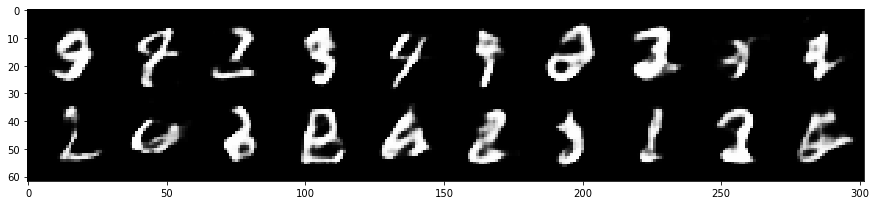

Model has finished training.

Training completed.


In [8]:
m = RunManager()
num_epochs = 150
num_samples = 20

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a network model
    ae = Autoencoder(hparams.latent_dim)

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=num_samples)
    test_images, _ = next(iter(test_loader))
    
    # Define random samples from standard Normal distribution for image generation
    sample_dim = (num_samples, hparams.latent_dim)
    test_latents = ae.sample(torch.zeros(sample_dim), torch.ones(sample_dim))
    
    # Define optimizer
    optimizer = optim.RMSprop(ae.parameters(), lr=hparams.init_lr, centered=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 60, 0.1)
    
    # Setup run instance
    m.begin_run(hparams, ae, test_images, test_latents)
    m.generate_images()
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, latent_dim={2}'
         .format(hparams.init_lr, hparams.batch_size, hparams.latent_dim))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, _ = batch

            # Calculating the loss
            elbo = ae(images)
            loss = -elbo
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_images, _ = next(iter(val_loader))
                    val_elbo = ae(val_images)
                    val_loss = -val_elbo
                    m.track_loss(val_loss, val_images.size(0), mode='val')
                print('Epoch {0}, iteration {1}: train loss {2}, val loss {3}'.format(epoch+1,
                                                                               i*hparams.batch_size,
                                                                               round(loss.item() / hparams.batch_size, 6),
                                                                               round(val_loss.item() / hparams.batch_size, 6)))
            
            # Zero all gradients and backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()
            
            m.track_loss(loss, images.size(0), mode='train')
            
        m.end_epoch()
    
    #torch.save(ae, './models/test_' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    scheduler.step()
    
m.save('results_final')
print("Training completed.")

## Evaluate model performance

In [9]:
ae_best = ae#torch.load('./models/Run(init_lr=0.0005, batch_size=128, latent_dim=256).pth')

Generating images...



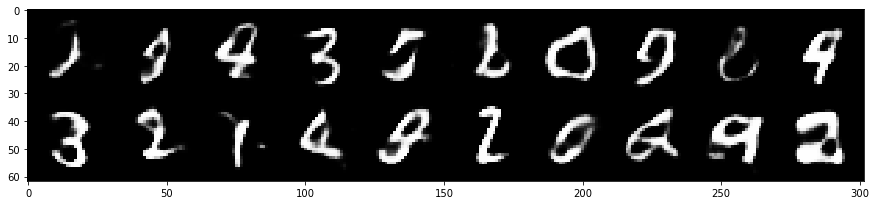

Test loss: 78.965525


In [10]:
num_samples = 20

print("Generating images...\n")
sample_dim = (num_samples, ae_best.latent_dim)
z_samples = ae_best.sample(torch.zeros(sample_dim), torch.ones(sample_dim))
with torch.no_grad():
    generated_imgs = nn.Sigmoid()(ae_best.decoder(z_samples))
    imgviz(generated_imgs)

# Test loss
test_loader = DataLoader(test_set, batch_size=len(test_set))
for i, batch in enumerate(test_loader):
    images, _ = batch
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        elbo = ae(images)
        loss = -elbo
print('Test loss:', loss.item() / len(test_set))

Latent dimension index: 0


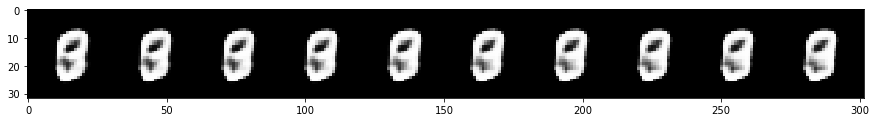

Latent dimension index: 1


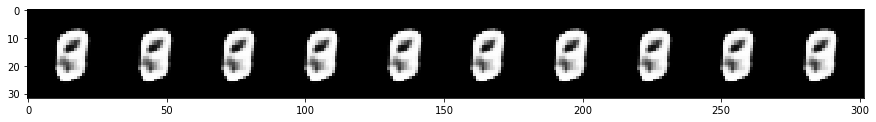

Latent dimension index: 2


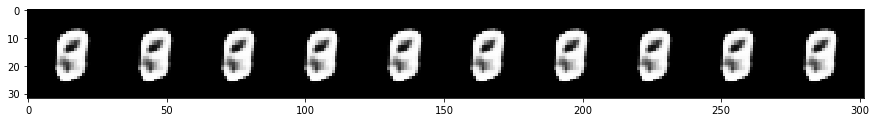

Latent dimension index: 3


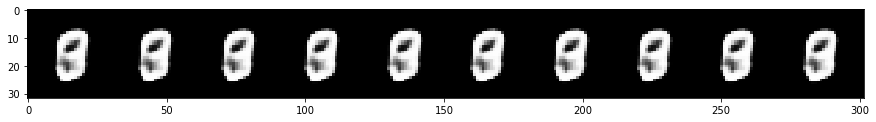

Latent dimension index: 4


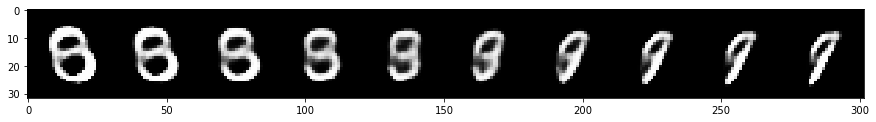

Latent dimension index: 5


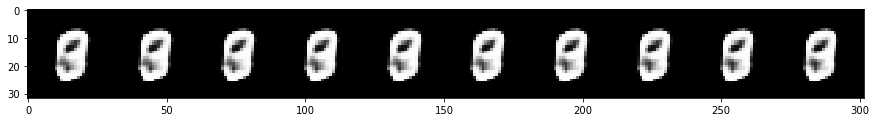

Latent dimension index: 6


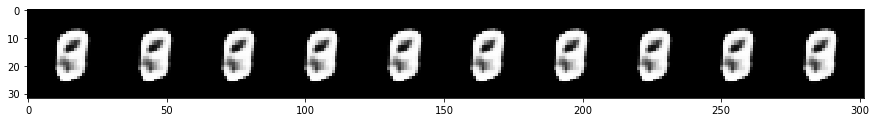

Latent dimension index: 7


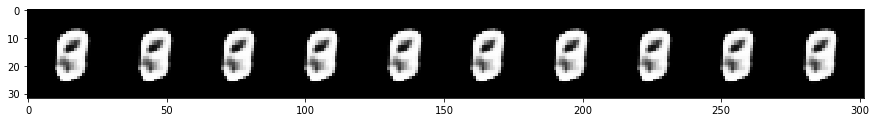

Latent dimension index: 8


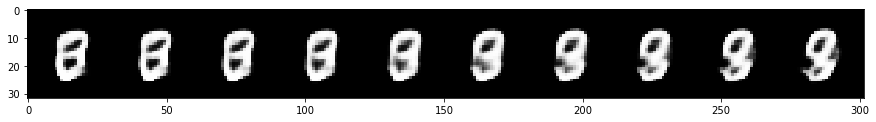

Latent dimension index: 9


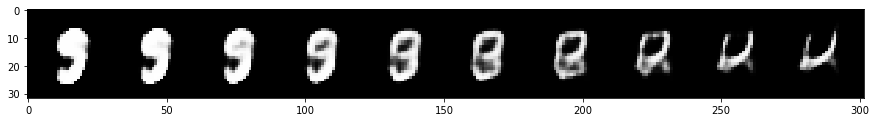

Latent dimension index: 10


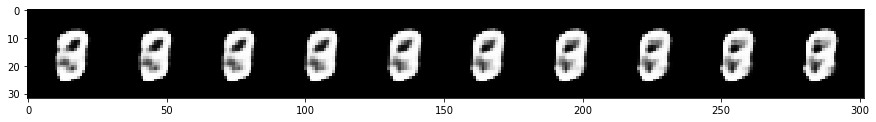

Latent dimension index: 11


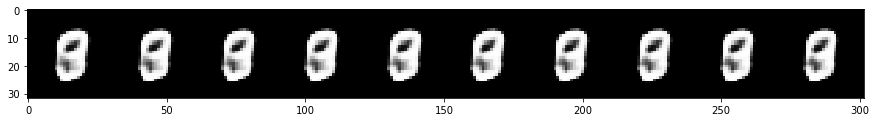

Latent dimension index: 12


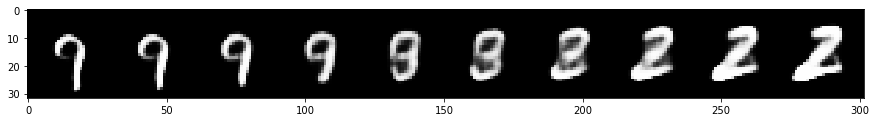

Latent dimension index: 13


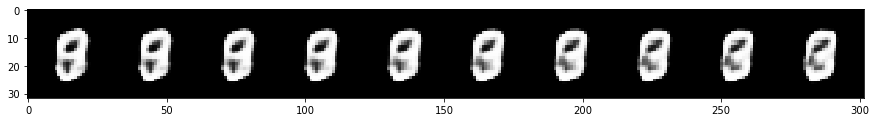

Latent dimension index: 14


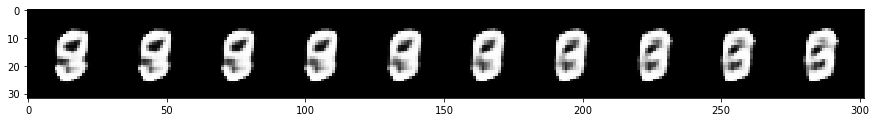

Latent dimension index: 15


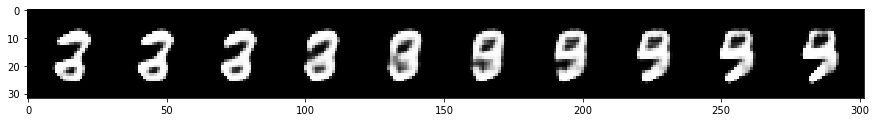

Latent dimension index: 16


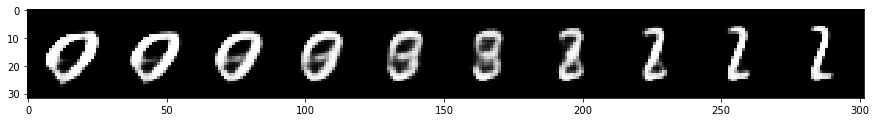

Latent dimension index: 17


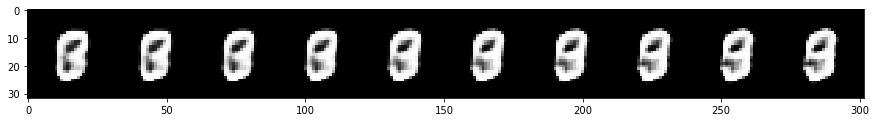

Latent dimension index: 18


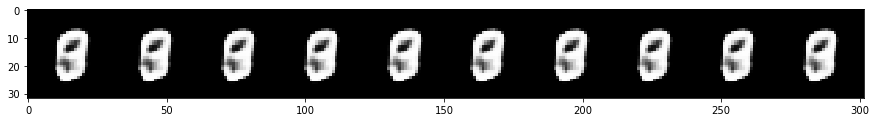

Latent dimension index: 19


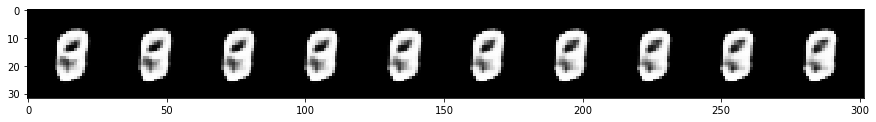

Latent dimension index: 20


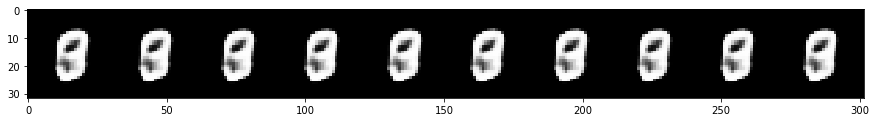

Latent dimension index: 21


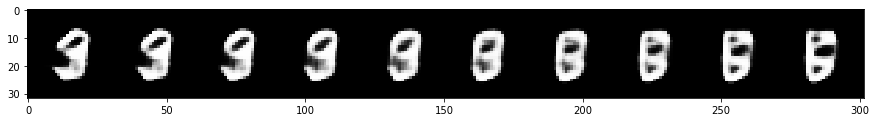

Latent dimension index: 22


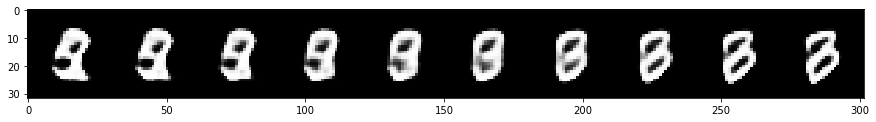

Latent dimension index: 23


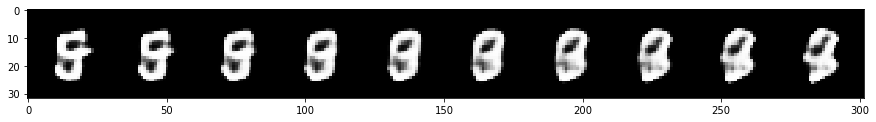

Latent dimension index: 24


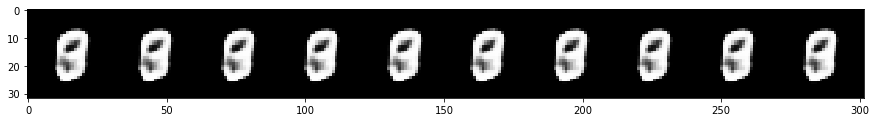

Latent dimension index: 25


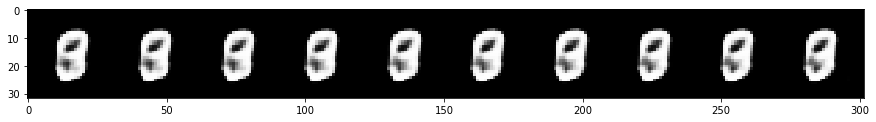

Latent dimension index: 26


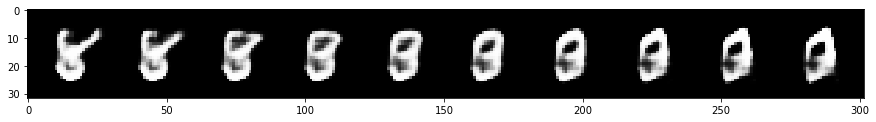

Latent dimension index: 27


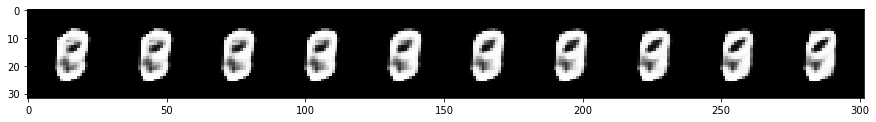

Latent dimension index: 28


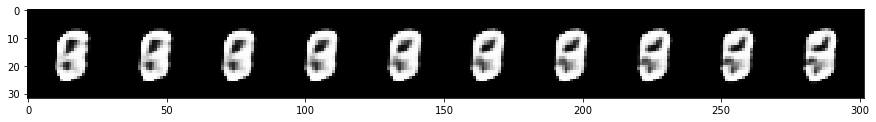

Latent dimension index: 29


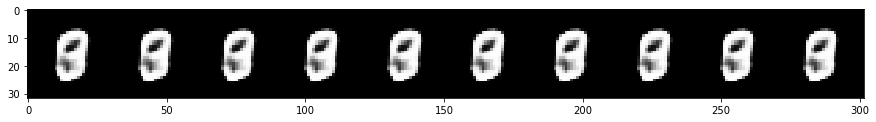

Latent dimension index: 30


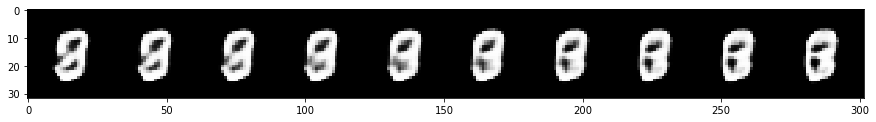

Latent dimension index: 31


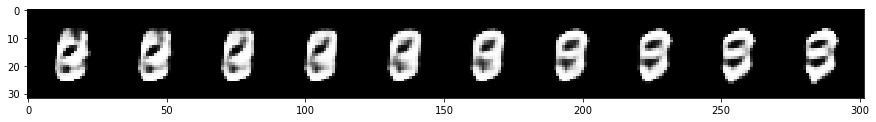

Latent dimension index: 32


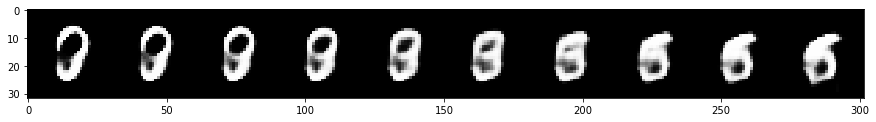

Latent dimension index: 33


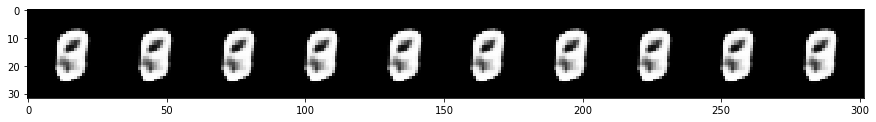

Latent dimension index: 34


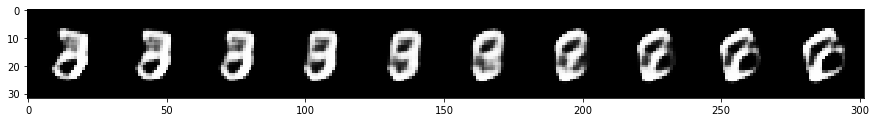

Latent dimension index: 35


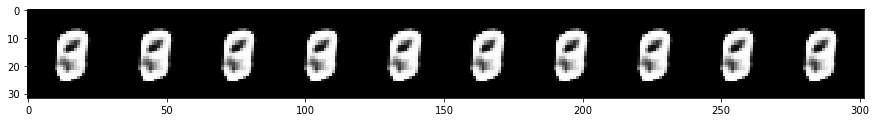

Latent dimension index: 36


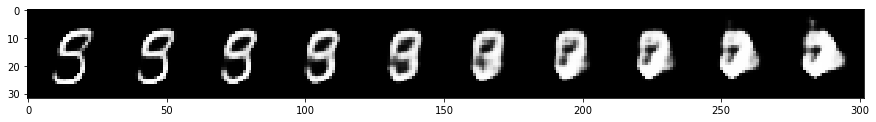

Latent dimension index: 37


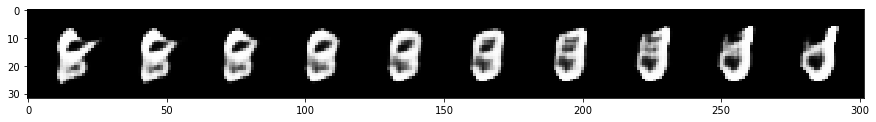

Latent dimension index: 38


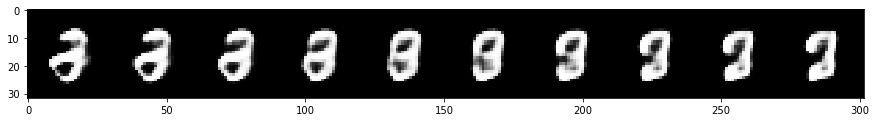

Latent dimension index: 39


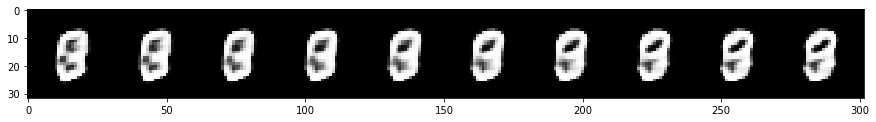

Latent dimension index: 40


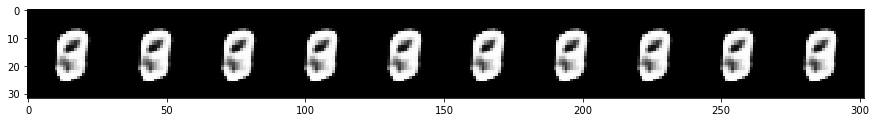

Latent dimension index: 41


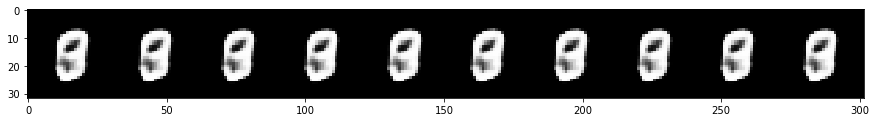

Latent dimension index: 42


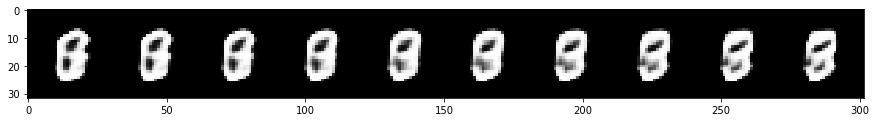

Latent dimension index: 43


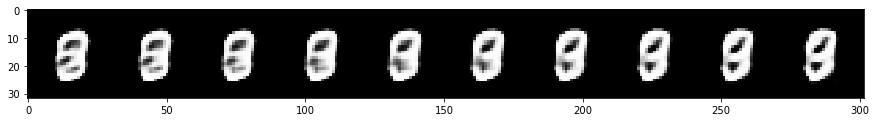

Latent dimension index: 44


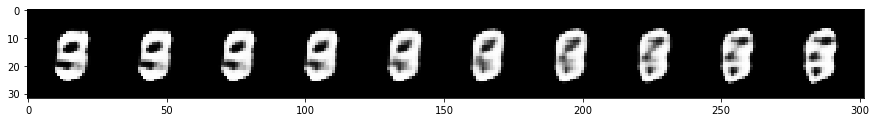

Latent dimension index: 45


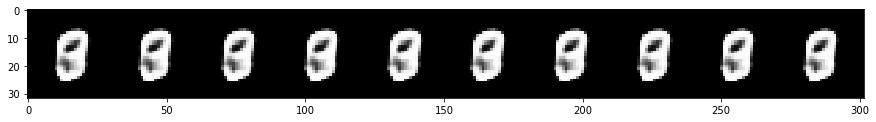

Latent dimension index: 46


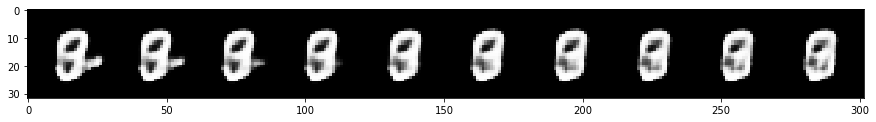

Latent dimension index: 47


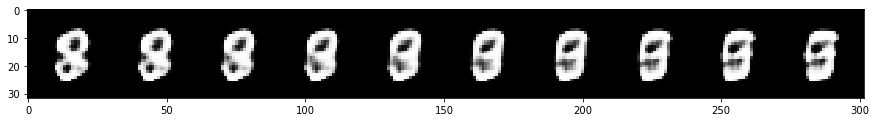

Latent dimension index: 48


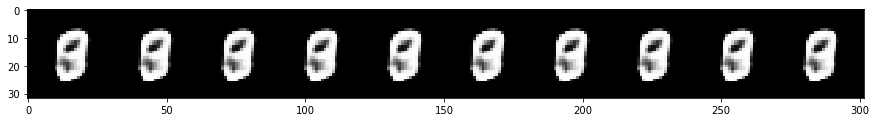

Latent dimension index: 49


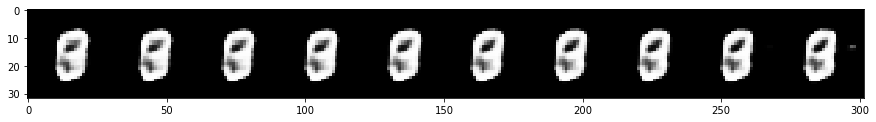

Latent dimension index: 50


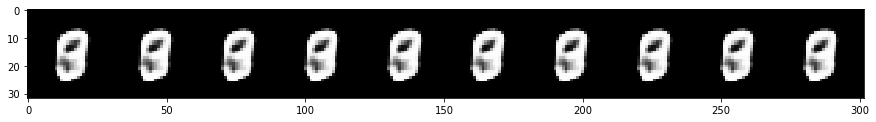

Latent dimension index: 51


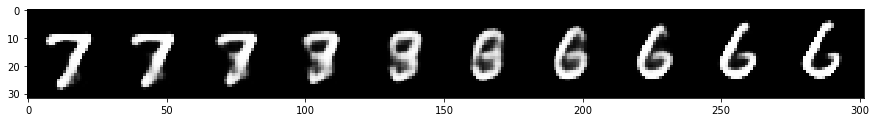

Latent dimension index: 52


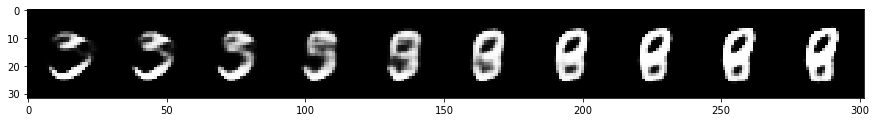

Latent dimension index: 53


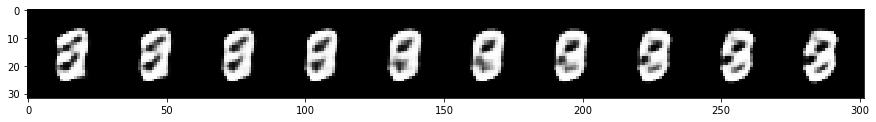

Latent dimension index: 54


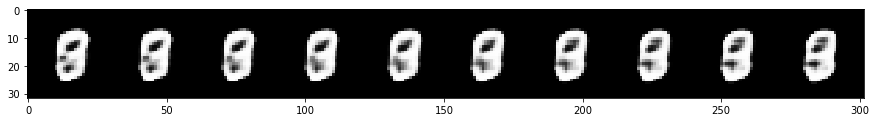

Latent dimension index: 55


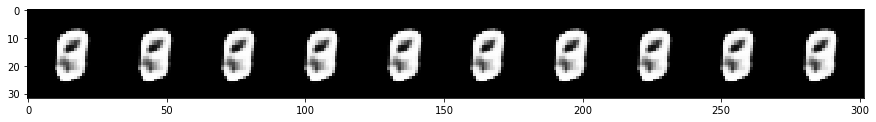

Latent dimension index: 56


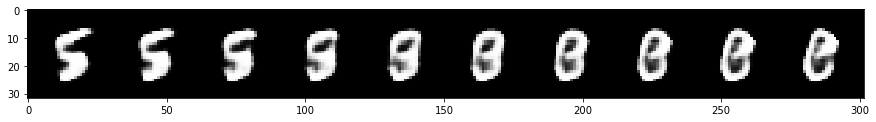

Latent dimension index: 57


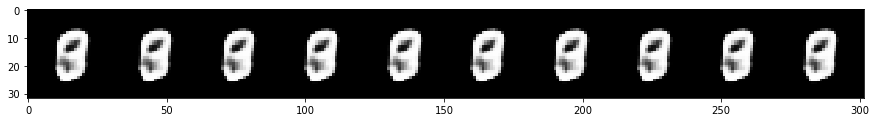

Latent dimension index: 58


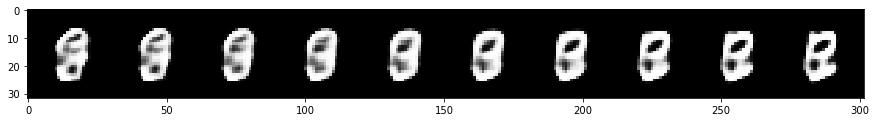

Latent dimension index: 59


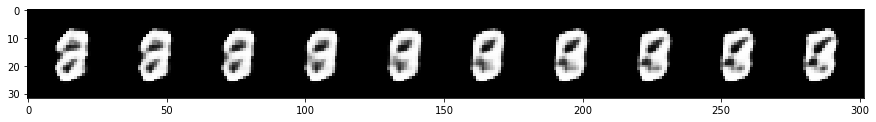

Latent dimension index: 60


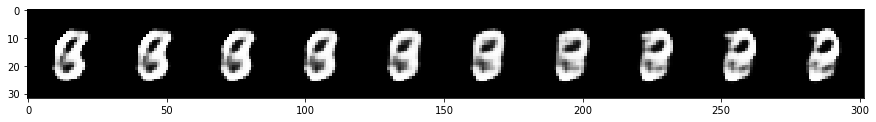

Latent dimension index: 61


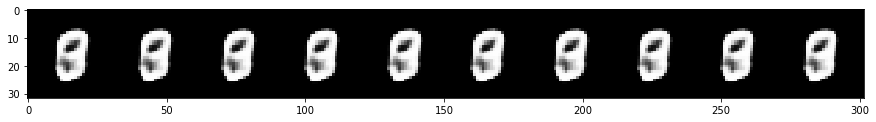

Latent dimension index: 62


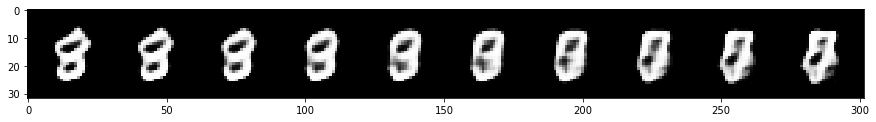

Latent dimension index: 63


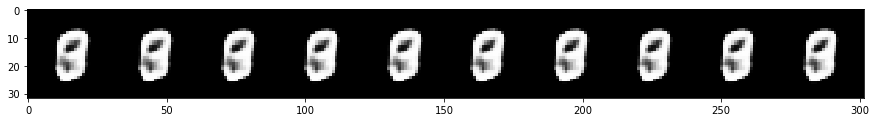

In [11]:
zs = np.linspace(-3, 3, 10)
for j in range(ae_best.latent_dim):
    latents = torch.zeros((10, ae_best.latent_dim))
    for i in range(10):
        latents[i,j] = zs[i]
    print("Latent dimension index:", j)
    with torch.no_grad():
        generated_imgs = nn.Sigmoid()(ae_best.decoder(latents))
        imgviz(generated_imgs)

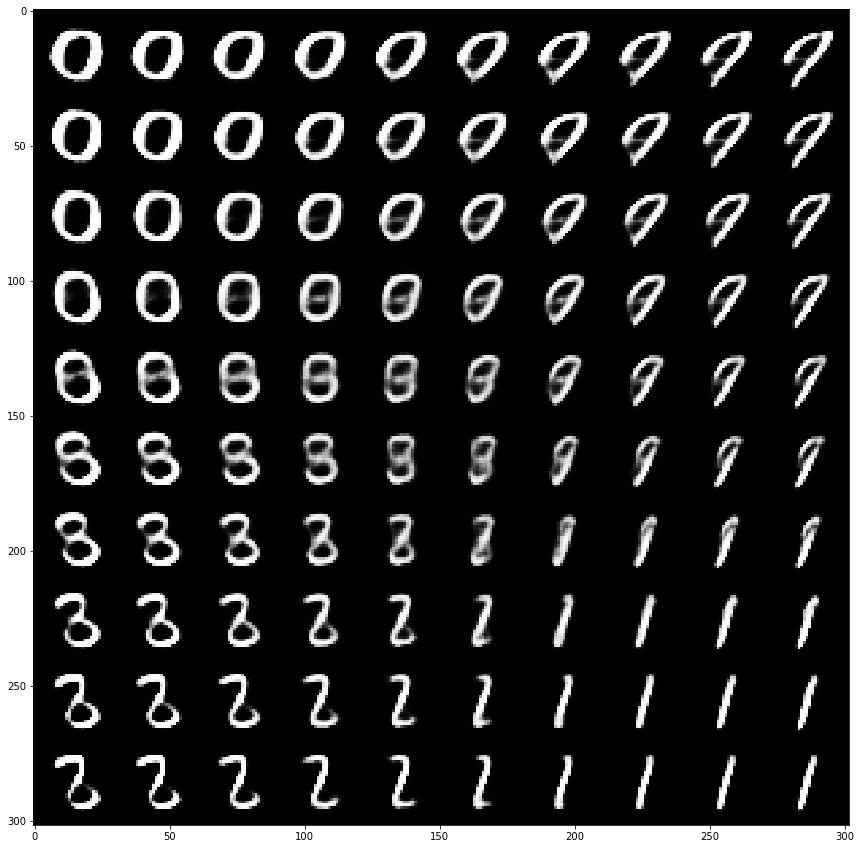

In [17]:
a = np.linspace(-3, 3, 10)
b0, b1 = np.meshgrid(a, a)
latents = torch.zeros((100, ae_best.latent_dim))
for i in range(10):
    for j in range(10):
        latents[i*10+j,4] = b0[i,j]
        latents[i*10+j,16] = b1[i,j]
with torch.no_grad():
    generated_imgs = nn.Sigmoid()(ae_best.decoder(latents))
    imgviz(generated_imgs, save_fname='img.png')

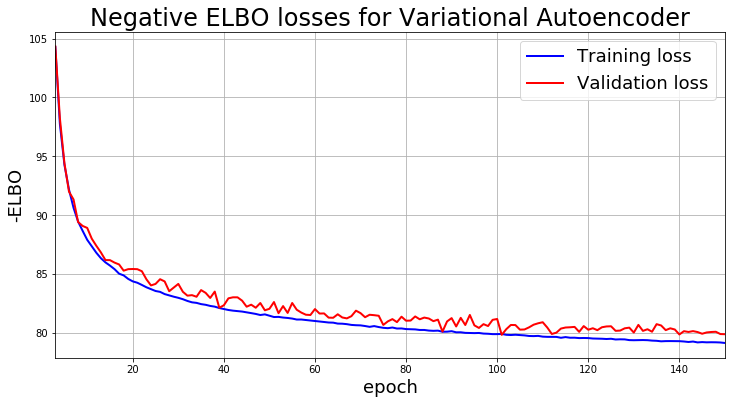

In [18]:
## Visualise losses in graph
train_losses = np.array([m.run.data[i]['train loss'] for i in range(2, len(m.run.data))])
val_losses = np.array([m.run.data[i]['validation loss'] for i in range(2, len(m.run.data))])
epochs = np.array(list(range(3, 151)))

figure = plt.figure(figsize=(12,6))
plt.plot(epochs, train_losses, 'b-', lw=2, label='Training loss')
plt.plot(epochs, val_losses, 'r-', lw=2, label='Validation loss')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('-ELBO', fontsize=18)
plt.title('Negative ELBO losses for Variational Autoencoder', fontsize=24)
plt.xlim([3,150])
plt.legend(fontsize=18)
plt.grid('on')
plt.savefig('./losses')
plt.show()